In [1]:
from matplotlib import pyplot as plt
from scipy.misc import imread
from types import MethodType
from os.path import exists
import tensorflow as tf
from glob import glob
import numpy as np

%matplotlib inline

np.random.seed(42)

# Data Import

In [2]:
def get_name(filepath):
    return filepath.split('/')[-1]

n_cracked   = len(glob('./Data/170729_Panel_Solos_Resized/CrackedScores/*.png'))
n_query     = 3

cracked_score_fps   = glob('./Data/170729_Panel_Solos_Resized/CrackedScores/*.png')
uncracked_score_fps = glob('./Data/170729_Panel_Solos_Resized/UncrackedScores/*.png') 

image_filepaths     = (['./Data/170729_Panel_Solos_Resized/Cracked/' + get_name(fp) 
                         for fp in cracked_score_fps] +
                       ['./Data/170729_Panel_Solos_Resized/Uncracked/' + get_name(fp)
                         for fp in uncracked_score_fps])

score_filepaths  = ( cracked_score_fps +
                      uncracked_score_fps )

scores  = np.expand_dims(np.array(
                [imread(fp) for fp in score_filepaths], dtype = 'float32'), axis = -1) / 255
scores  = np.concatenate([scores, 1 - scores], axis = -1) # 'One-hot' encode scores
images  = np.expand_dims(np.array(
                [imread(fp) for fp in image_filepaths], dtype = 'float32'), axis = -1)
images  = (images - 128)/128

query_ix     = np.random.randint(0, n_cracked, 3)
query_mask   = np.zeros([scores.shape[0]], dtype = bool)
query_mask[query_ix] = True

query_scores = scores[query_mask, :, :, :]
query_images = images[query_mask, :, :, :]
scores       = scores[np.logical_not(query_mask), :, :, :]
images       = images[np.logical_not(query_mask), :, :, :]

labels       = (np.sum(scores, axis = (1, 2)) > 0).squeeze()[:, 0]

print('Images and score masks successfully read.')

Images and score masks successfully read.


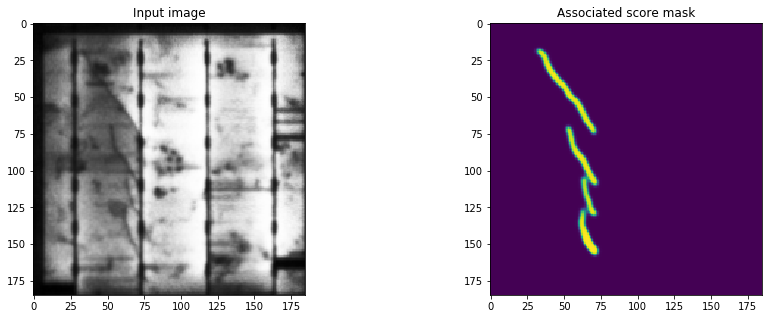

In [3]:
f, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].imshow(query_images[0, :, :, 0], cmap = 'gray'); axs[0].set_title('Input image')
axs[1].imshow(query_scores[0, :, :, 0]); axs[1].set_title('Associated score mask');

# Graph Definition

In [39]:
def define_variables(self):
    variables = {
                    'InputLayer' : BatchNormalizedConvLayer(1, 1, 8),
                    'LayerOne'   : BatchNormalizedConvLayer(3, 8, 16),      
                    'TallLayer'  : BatchNormalizedConvLayer([40, 10], 8, 8), # Tall layer outputs a 4-channel image
                    'LayerTwo'   : BatchNormalizedConvLayer(3, 16, 64),
                    'LayerThree' : BatchNormalizedConvLayer(1, 64, 8),
                    'LayerFour'  : BatchNormalizedConvLayer(5, 8, 16),
                    'OutputLayer': BatchNormalizedConvLayer(1, 24, 2, activate = False) # 4 from tall layer, 16 from LayerFour
                }
    return variables

def W185_P40k_Tall(self, mode, variables):
    """
        Defines sequences of operations constituting network. Refers to variables defined by <self.variables> dict.
    """
    self.ops['L0_1'] = variables['InputLayer'].apply(mode, self.images)
    self.ops['L1_1'] = variables['LayerOne'].apply(mode, self.ops['L0_1'])
    self.ops['L1_2'] = variables['TallLayer'].apply(mode, self.ops['L0_1'])
    self.ops['L2_1'] = variables['LayerTwo'].apply(mode, self.ops['L1_1'])
    self.ops['L3_1'] = variables['LayerThree'].apply(mode, self.ops['L2_1'])
    self.ops['L4_1'] = variables['LayerFour'].apply(mode, self.ops['L3_1'])
    self.ops['L5_1'] = tf.concat([ self.ops['L4_1'], self.ops['L1_2'] ],
                                         axis = -1)
    self.ops['logits'] = variables['OutputLayer'].apply(mode, self.ops['L5_1'])
    
    return self.ops['logits']

In [40]:
cnn = CNNModel(define_variables, W185_P40k_Tall, model_id = 'W185_P40k_Tall_W2CE')
cnn.compile_graph()

In [41]:
training_steps = 10001
batch_size     = 16
clear_previous = True

with tf.Session(graph = cnn.graph) as session:
    
    if exists('./Checkpoints/' + cnn.model_id + '.index') and not clear_previous:
        print('Restoring model...')
        cnn.saver.restore(session, './Checkpoints/' + cnn.model_id)
        
        print(' Model restored. Continuing to train...\n\n')
    else:
        print('Training initialized.\n\n')
        session.run(tf.global_variables_initializer())
        
    train_writer = tf.summary.FileWriter('./Results/' + cnn.model_id + '/train', session.graph)
    test_writer  = tf.summary.FileWriter('./Results/' + cnn.model_id + '/test', session.graph)
    
    for _ in range(training_steps):
        minibatch_images, minibatch_scores = get_minibatch(batch_size,
                                                           images, scores, labels)
        fd = { cnn.images       : minibatch_images,
               cnn.ground_truth : minibatch_scores }
        _, l, summary, step = session.run([ cnn.optimize, cnn.training_loss,
                                            cnn.training_summary, cnn.global_step ], feed_dict = fd)
        train_writer.add_summary(summary, step)
        
        if step % 100 == 0:
            print('Mean minibatch cross-entropy @ step {:^5d}: {:>3.3f}'.format(step, l))

        if step % 500 == 0:
            fd   = { cnn.images       : query_images,
                     cnn.ground_truth : query_scores }
            summary, step = session.run([cnn.testing_summary,
                                         cnn.global_step ], feed_dict = fd)
            test_writer.add_summary(summary, step)
            
    cnn.saver.save(session, './Checkpoints/' + cnn.model_id)
    train_writer.close()
    test_writer.close()

Training initialized.


Mean minibatch cross-entropy @ step  100 : 0.655
Mean minibatch cross-entropy @ step  200 : 0.616
Mean minibatch cross-entropy @ step  300 : 0.577
Mean minibatch cross-entropy @ step  400 : 0.537
Mean minibatch cross-entropy @ step  500 : 0.501
Mean minibatch cross-entropy @ step  600 : 0.459
Mean minibatch cross-entropy @ step  700 : 0.423
Mean minibatch cross-entropy @ step  800 : 0.389
Mean minibatch cross-entropy @ step  900 : 0.358
Mean minibatch cross-entropy @ step 1000 : 0.326
Mean minibatch cross-entropy @ step 1100 : 0.297
Mean minibatch cross-entropy @ step 1200 : 0.271
Mean minibatch cross-entropy @ step 1300 : 0.251
Mean minibatch cross-entropy @ step 1400 : 0.225
Mean minibatch cross-entropy @ step 1500 : 0.206
Mean minibatch cross-entropy @ step 1600 : 0.187
Mean minibatch cross-entropy @ step 1700 : 0.173
Mean minibatch cross-entropy @ step 1800 : 0.161
Mean minibatch cross-entropy @ step 1900 : 0.141
Mean minibatch cross-entropy @ step 2000 : 0.